<a href="https://colab.research.google.com/github/seunghak421/section2_project/blob/main/%08AI_13_%EB%B0%B1%EC%8A%B9%ED%95%99_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

뇌졸중


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_stroke='/content/drive/MyDrive/Stroke.csv'

In [3]:
import pandas as pd
df=pd.read_csv(data_stroke)

In [4]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
#이거 드롭하지말고 평균값으로 바꿀까??
df['bmi'] = df['bmi'].fillna(value=df['bmi'].mean())

In [7]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
df=df.rename(columns={'ever_married':'married','avg_glucose_level':'glucose_level','smoking_status':'smoke','Residence_type':'Residence'})

In [9]:
df.gender.replace({'Male':1,'Female':0,'Other':2},inplace = True)
df.married.replace({'Yes':1,'No':0},inplace = True)
df.Residence.replace({'Urban':1,'Rural':0},inplace = True)
df.smoke.replace({'smokes':1,'never smoked':0,'formerly smoked':3,'Unknown':4},inplace = True)

In [10]:
df['smoke'].unique()

array([3, 0, 1, 4])

In [11]:
df['work_type']

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

In [12]:
df.describe()

,id,gender,age,hypertension,heart_disease,married,Residence,glucose_level,bmi,smoke,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,0.414286,43.226614,0.097456,0.054012,0.656164,0.508023,106.147677,28.893237,1.882583,0.048728
std,21161.721625,0.493044,22.612647,0.296607,0.226063,0.475034,0.499985,45.283560,7.698018,1.733212,0.215320
min,67.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000
25%,17741.250000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.245000,23.800000,0.000000,0.000000
50%,36932.000000,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.885000,28.400000,1.000000,0.000000
75%,54682.000000,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.090000,32.800000,4.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,97.600000,4.000000,1.000000


In [13]:
df.drop('id',axis=1,inplace=True)


In [14]:
df.drop('married',axis=1,inplace=True)

In [15]:
target='stroke'

In [16]:
#프로젝트에 사용할 데이터는 뇌졸증 환자들에 관한 데이터 입나다.
#나이,성별,고혈압,심장질환,결혼여부,거주지,혈당,체질량,흡연여부로 데이터셋을 구성합니다.
#타겟은 뇌졸증 입니다.

In [17]:
df['stroke'].value_counts(normalize = True)
#클래스 2개 비율-> 불균형
#분류
#불균형 데이터 (accuracy만 사용해서는 안된다.)
#오차행렬,정밀도와 재현율,f1스코어,roc곡선과 auc등 을 같이 사용한다.

0    0.951272
1    0.048728
Name: stroke, dtype: float64

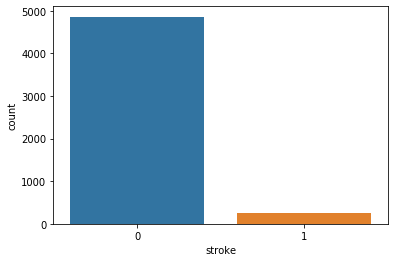

In [18]:
import seaborn as sns
tmp = df['stroke']
sns.countplot(x=tmp)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

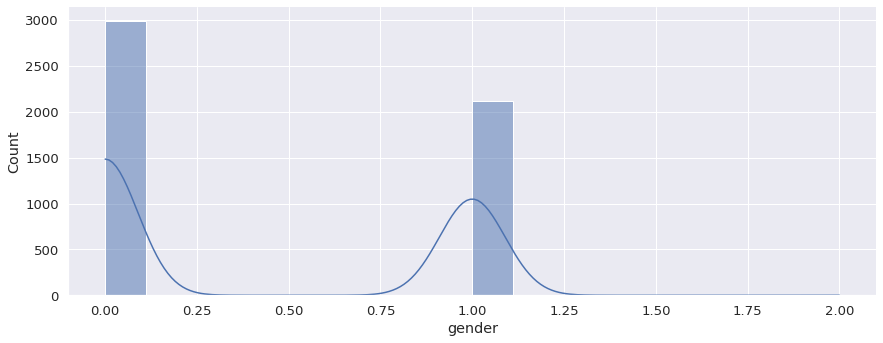

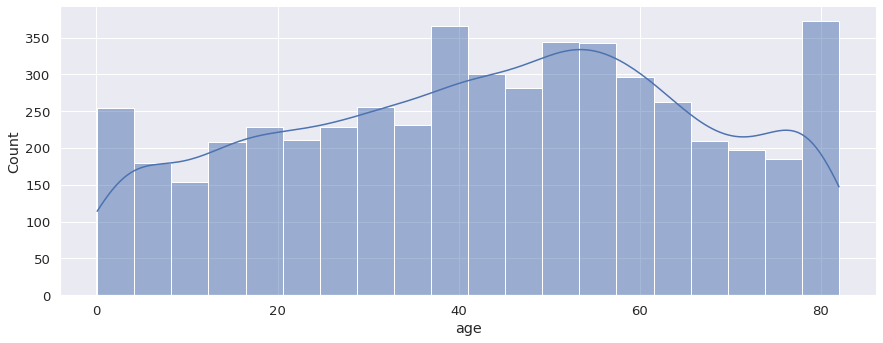

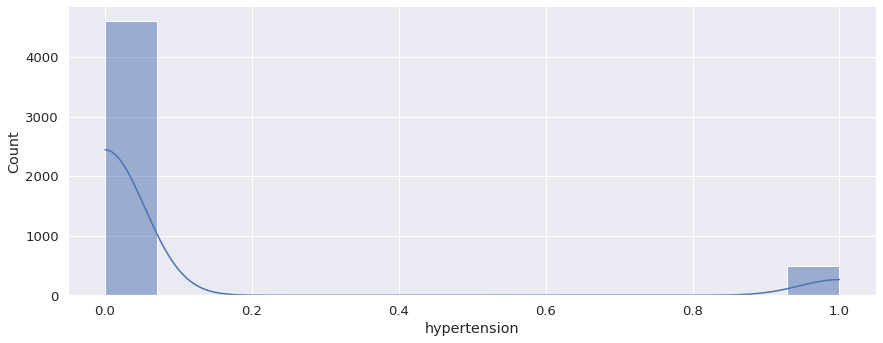

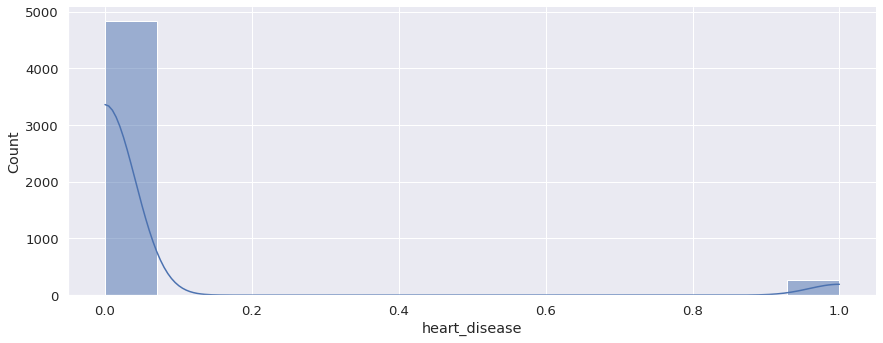

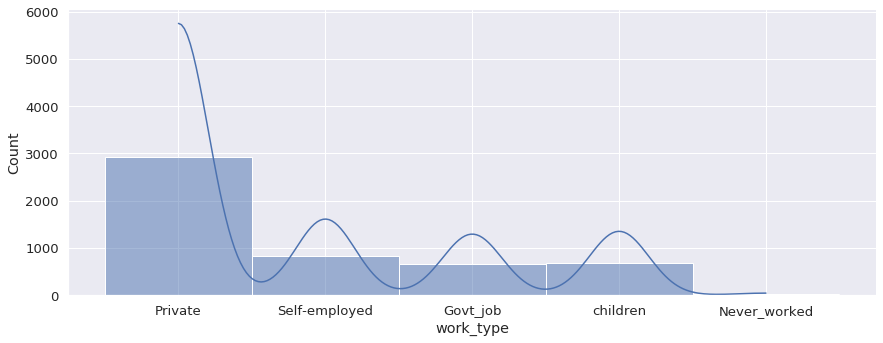

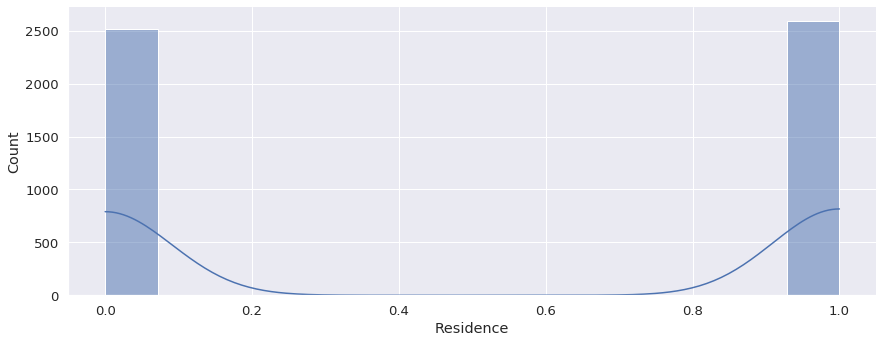

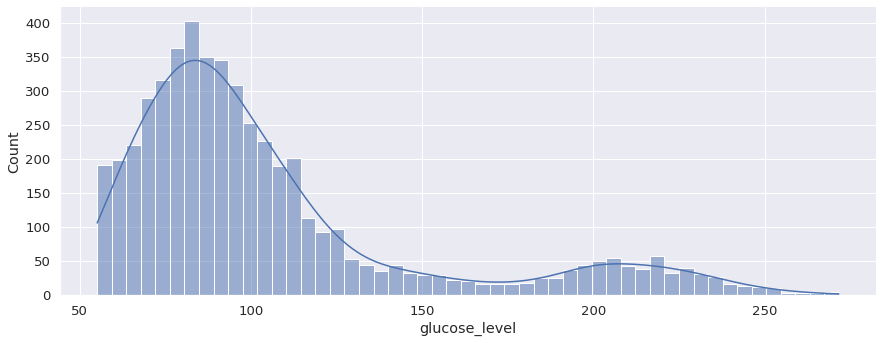

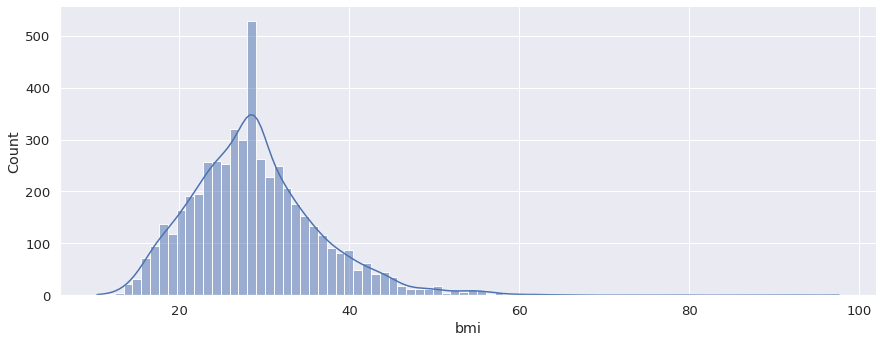

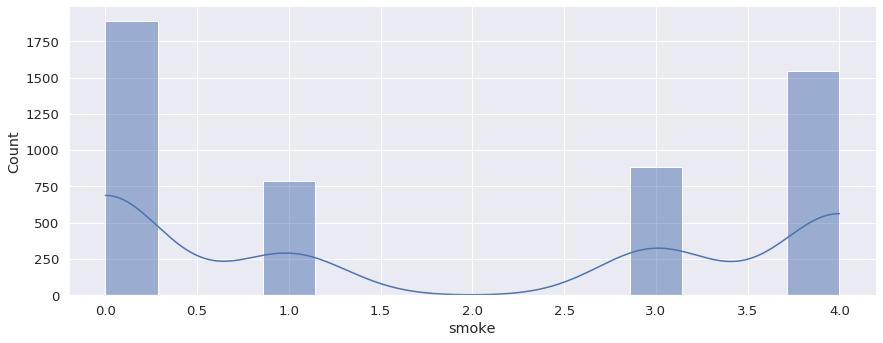

In [19]:
other = df.drop(['stroke'],axis=1).columns
sns.set(font_scale=1.2)

for i in other:
  sns.displot(df[i], height = 5, aspect = 2.5, kde=True);

In [20]:
#성별,나이,고혈압,심장병,거주지역,포도당 수치,체질량지수,흡연여부

In [21]:
#결혼,직업은 버리자

# 가설
나이가 많아질수록 뇌졸중에 걸릴확률이 높다.
고혈압환자가


In [22]:
#가설


# 평가지표
불균형 분포이다.
'f1 score'와 'roc_auc score'를 평가지표로 사용할 것이다.

In [23]:
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [24]:
# 불균형 클래스 가중치 
ratio = 0.951272/0.048728

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


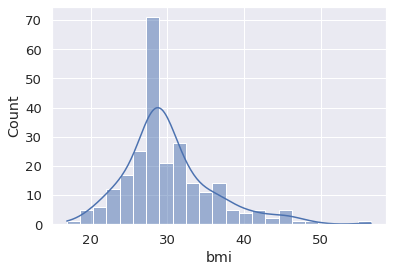

In [25]:
# 가설 1
sick = df[df['stroke'] == 1]
sns.histplot(sick['bmi'],kde=True);

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


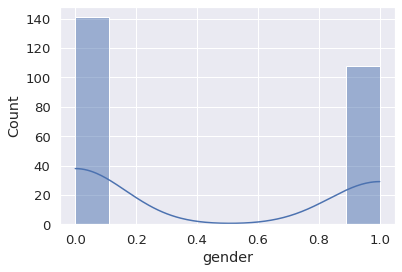

In [26]:
sns.histplot(sick['gender'],kde=True);

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


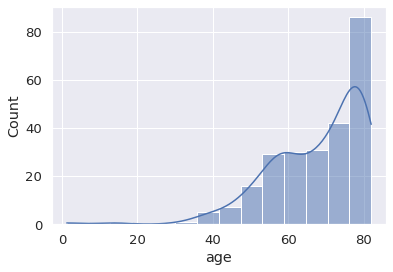

In [27]:
#나이와의 관계
sns.histplot(sick['age'],kde=True);

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


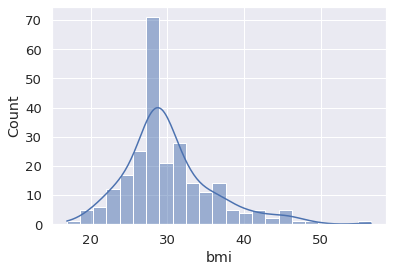

In [28]:
sns.histplot(sick['bmi'],kde=True);

# 모델 학습

In [29]:
target = 'stroke'
feature = df.drop(columns=[target]).columns

# test/train/val으로 데이터셋 구분하기
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=2)
train, val = train_test_split(train, random_state=2)

# 훈련세트-독립/종속변수 지정 + 테스트세트-독립/종속변수 지정
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]
X_val = val[feature]
y_val = val[target]

In [30]:
train.shape, val.shape, test.shape

((2874, 10), (958, 10), (1278, 10))

In [31]:
!pip install category_encoders
!pip install pdpbox
!pip install eli5
!pip install catboost

In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from ipywidgets import interact, fixed
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [33]:
# 1차 기본모델: logistic regression
from sklearn.linear_model import LogisticRegression
log = make_pipeline( 
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()
)

log.fit(X_train, y_train)
y_pred = log.predict(X_val)
print('훈련 정확도', log.score(X_train, y_train))
print('검증 정확도', log.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

훈련 정확도 0.9516353514265832
검증 정확도 0.9509394572025052
Report 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       911
           1       0.00      0.00      0.00        47

    accuracy                           0.95       958
   macro avg       0.48      0.50      0.49       958
weighted avg       0.90      0.95      0.93       958

f1 스코어 0.0
auc점수 :  0.5


In [34]:
# 1차 기본모델: RF
pipe = make_pipeline( 
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=2)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

훈련 정확도 0.999652052887961
검증 정확도 0.9498956158663883
Report 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       911
           1       0.00      0.00      0.00        47

    accuracy                           0.95       958
   macro avg       0.48      0.50      0.49       958
weighted avg       0.90      0.95      0.93       958

f1 스코어 0.0
auc점수 :  0.4994511525795829


In [50]:
# 1차 기본모델: XGBoost
pipe_x = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=ratio, random_state=24,n_estimatiors=10,max_depth=3,n_jobs=-1))

pipe_x.fit(X_train, y_train)
y_predx = pipe_x.predict(X_val)
print('훈련 정확도', pipe_x.score(X_train, y_train))
print('검증 정확도', pipe_x.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_predx))
print('f1 스코어',f1_score(y_val, y_predx))
print('auc점수 : ', roc_auc_score(y_val, y_predx))

훈련 정확도 0.8152400835073069
검증 정확도 0.7881002087682673
Report 
               precision    recall  f1-score   support

           0       0.98      0.79      0.88       911
           1       0.15      0.70      0.25        47

    accuracy                           0.79       958
   macro avg       0.56      0.75      0.56       958
weighted avg       0.94      0.79      0.85       958

f1 스코어 0.24535315985130113
auc점수 :  0.7473316673283976


In [51]:
# 1.xgboost
pipe_xc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=ratio, random_state=2)
)

distsxc = {  
    'ordinalencoder__handle_missing': ['value'],
    'simpleimputer__strategy': ['mean', 'median'], 
    'xgbclassifier__n_estimators': randint(50, 500), 
    'xgbclassifier__max_depth': randint(0, 15),
    'xgbclassifier__min_samples_leaf': randint(2, 20)
}

clfxg = RandomizedSearchCV(
    pipe_xc, 
    param_distributions=distsxc, 
    n_iter=30, 
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clfxg.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [52]:
print('최적 하이퍼파라미터: ', clfxg.best_params_)

pipe_xg = clfxg.best_estimator_
y_val_predxg = pipe_xg.predict(X_val)
y_train_predxg = pipe_xg.predict(X_train)
print('훈련 f1 score: ', f1_score(y_train, y_train_predxg))
print('검증 f1 score: ', f1_score(y_val, y_val_predxg))
print('Report \n',classification_report(y_val, y_val_predxg))
print('auc점수 : ', roc_auc_score(y_val, y_val_predxg))

최적 하이퍼파라미터:  {'ordinalencoder__handle_missing': 'value', 'simpleimputer__strategy': 'mean', 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_samples_leaf': 17, 'xgbclassifier__n_estimators': 65}
훈련 f1 score:  0.4483870967741935
검증 f1 score:  0.28292682926829266
Report 
               precision    recall  f1-score   support

           0       0.98      0.86      0.91       911
           1       0.18      0.62      0.28        47

    accuracy                           0.85       958
   macro avg       0.58      0.74      0.60       958
weighted avg       0.94      0.85      0.88       958

auc점수 :  0.7377093210640634


roc


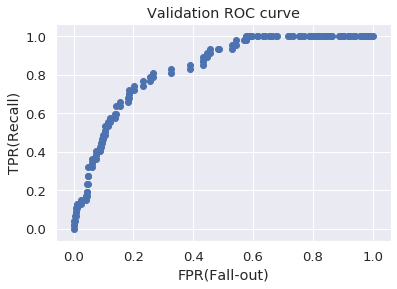

In [38]:
from sklearn.metrics import roc_curve

y_pred_proba = pipe_xg.predict_proba(X_val)[:, 1]

# roc_curve(타겟값, prob of 1)
fprv, tprv, thresholdsv = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fprv, 
    'TPRate(Recall)': tprv, 
    'Threshold': thresholdsv
})

plt.scatter(fprv, tprv)
plt.title('Validation ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 67 , threshold: 0.15132625


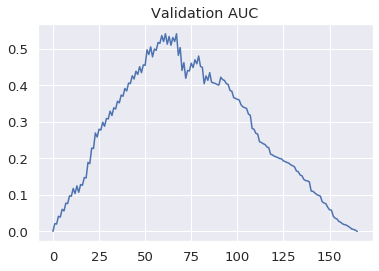

In [39]:
# 최적의 threshold & AUC
optimal_idxv = np.argmax(tprv - fprv)
optimal_thresholdv = thresholdsv[optimal_idxv]

print('idx:', optimal_idxv, ', threshold:', optimal_thresholdv)
plt.title('Validation AUC')
plt.plot(tprv-fprv);

In [40]:
# threshold 설정 및 레포트
y_v_pred_optimal = y_pred_proba >= optimal_thresholdv
print('Report \n',classification_report(y_val, y_v_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_v_pred_optimal)
print('검정 정확도', pipe_xg.score(X_val, y_val))
print('val_f1 스코어',f1_score(y_val, y_v_pred_optimal))
print('val_auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.99      0.73      0.84       911
           1       0.14      0.81      0.23        47

    accuracy                           0.74       958
   macro avg       0.56      0.77      0.54       958
weighted avg       0.94      0.74      0.81       958

검정 정확도 0.8789144050104384
val_f1 스코어 0.23170731707317074
val_auc점수 :  0.7708853959875751


# 최종

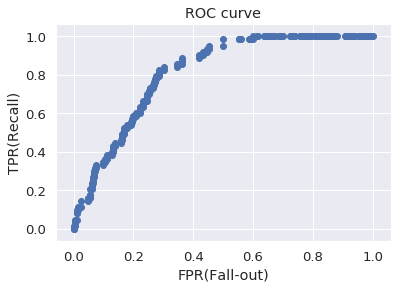

In [41]:
# 테스트 데이터 모델에 넣어서 roc curve
y_test_pred_proba = pipe_xg.predict_proba(X_test)[:, 1]

# roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 100 , test_threshold: 0.12940162


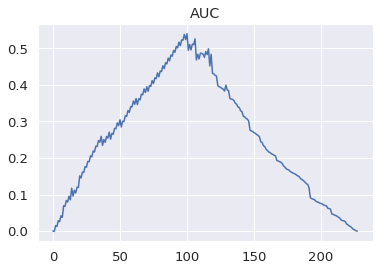

In [42]:
# 최적의 threshold & AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', test_threshold:', optimal_threshold)
plt.title('AUC')
plt.plot(tpr-fpr);

In [43]:
# threshold 설정 및 레포트
y_test_pred_optimal = y_test_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_test, y_test_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_test_pred_optimal)
print('테스트 정확도', pipe_xg.score(X_test, y_test))
print('test_f1 스코어',f1_score(y_test, y_test_pred_optimal))
print('test_auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.99      0.70      0.82      1215
           1       0.13      0.84      0.22        63

    accuracy                           0.71      1278
   macro avg       0.56      0.77      0.52      1278
weighted avg       0.95      0.71      0.79      1278

테스트 정확도 0.8748043818466353
test_f1 스코어 0.21991701244813278
test_auc점수 :  0.7700176366843035


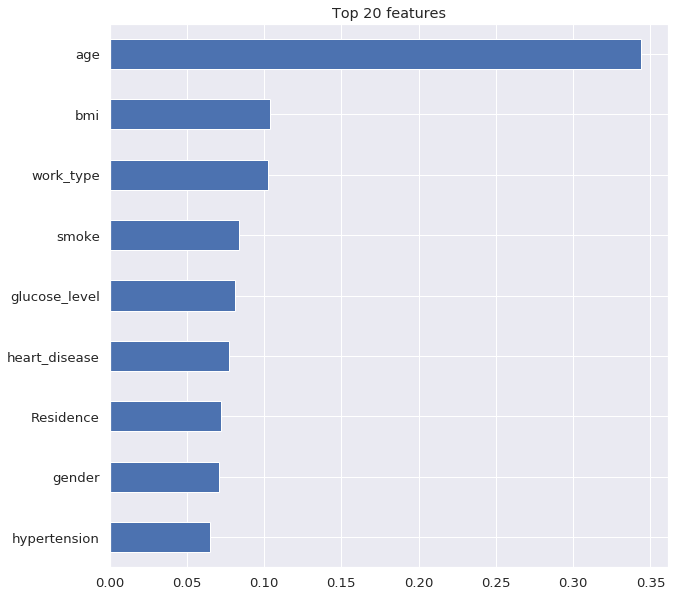

In [44]:
# feature importance
processor = make_pipeline(
    OrdinalEncoder(handle_missing='value'), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

model = XGBClassifier(learning_rate=0.2, max_depth= 4, n_estimators=308, 
                           scale_pos_weight=ratio, random_state=2).fit(X_train_processed, y_train)

importances = pd.Series(model.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();